<img src="C:\Users\USER\Downloads\dataset-cover.jpg" width="1000" style="max-height: 500px;"/>


### A Machine Learning Approach to Predicting COVID-19 Mortality Rates Based on Key Features

### Introduction

This notebook aims to predict COVID-19 deaths using various data analysis and machine learning methods. The study begins with exploratory data analysis (EDA) to understand trends in recovery and death rates across different countries. Key features such as confirmed cases, deaths, recoveries, and population data are selected and scaled for the model.

A correlation analysis identifies the strongest predictors of COVID-19 deaths, which guides feature selection. The XGBoost regressor model is then trained to predict the number of deaths, and its performance is evaluated using metrics like Mean Squared Error (MSE), R-squared (R²), and Mean Absolute Error (MAE).

Through this analysis, we aim to uncover insights into COVID-19 mortality patterns and develop a predictive framework that can assist in managing the pandemic's impact.

## 1. Data Loading and Preparation

Importing Necessary Libraries

First, we need to import the essential libraries for data manipulation, analysis, visualization, and machine learning:

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
from xgboost import plot_importance

### Load datasets

In [2]:
worldometer_df = pd.read_csv(r'C:\Users\USER\Documents\Covid 19 data\worldometer_data.csv')
full_grouped_df = pd.read_csv(r'C:\Users\USER\Documents\Covid 19 data\full_grouped.csv')


#### Data cleaning
Removes duplicates and converts the 'Date' column to datetime format in order to clean and prepare the full_grouped_df DataFrame. combines the selected_population_data DataFrame with the full_grouped_df according to the 'Country/Region' column. The average population is used to fill in the gaps in the population data. looks for any missing values that might still be present in the combined DataFrame.



In [3]:
full_grouped_df['Date'] = pd.to_datetime(full_grouped_df['Date'])
full_grouped_df = full_grouped_df.drop_duplicates()
population_columns = ['Country/Region', 'Population']
selected_population_data = worldometer_df[population_columns]
merged_df = pd.merge(full_grouped_df, selected_population_data, on='Country/Region', how='left')
average_population = merged_df['Population'].mean()
merged_df['Population'] = merged_df['Population'].fillna(average_population)
#print(merged_df.isnull().sum())


# Now, 'merged_df' will contain the merged data with no missing population values

This sample of code Z-score standardisation is used to find outliers in the 'Population' column. replaces the outlier values with the population average. eliminates the temporary Z-score column. looks for missing values and prints the number of outliers.

Number of outliers detected: 188
Date              0
Country/Region    0
Confirmed         0
Deaths            0
Recovered         0
Active            0
New cases         0
New deaths        0
New recovered     0
WHO Region        0
Population        0
dtype: int64


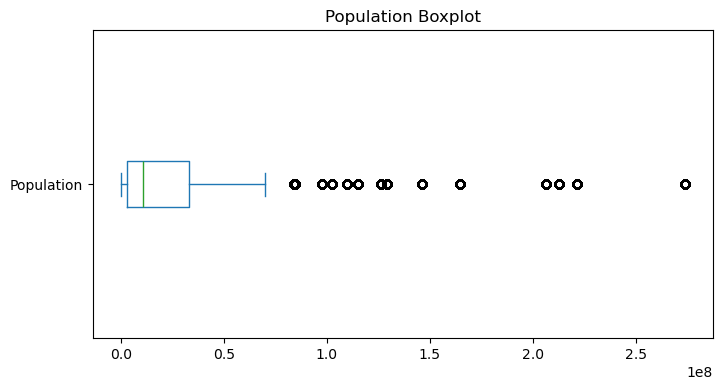

In [4]:
merged_df['Population_Z'] = (merged_df['Population'] - merged_df['Population'].mean()) / merged_df['Population'].std()
z_threshold = 3
outliers = merged_df[abs(merged_df['Population_Z']) > z_threshold]
average_population = merged_df['Population'].mean()
merged_df.loc[abs(merged_df['Population_Z']) > z_threshold, 'Population'] = average_population
merged_df = merged_df.drop(columns=['Population_Z'])

# Print the number of outliers detected and check for missing values
print(f"Number of outliers detected: {len(outliers)}")
print(merged_df.isnull().sum())

# Plot a boxplot to visualize the updated Population distribution
merged_df['Population'].plot(kind='box', vert=False, figsize=(8, 4), title='Population Boxplot')
plt.show()


The box plot shows that the population data is skewed to the right, with a few countries having significantly larger populations than the majority.
The outliers on the right side likely represent highly populated countries like China, India, and the United States.
The relatively small IQR suggests that a significant portion of countries have similar population sizes.

## 2. Exploratory Data Analysis (EDA)

### 2. 1 Trend of COVID-19 Cases Over Time
Analyze the trend of confirmed, recovered, and death cases over time to understand the overall progression of the pandemic.


This code summarizes the COVID-19 data by date, ensuring a daily timeseries. Then, it plots the trends of active cases, confirmed cases, recovered cases, and deaths over time, providing a visual representation of the pandemic's progression.

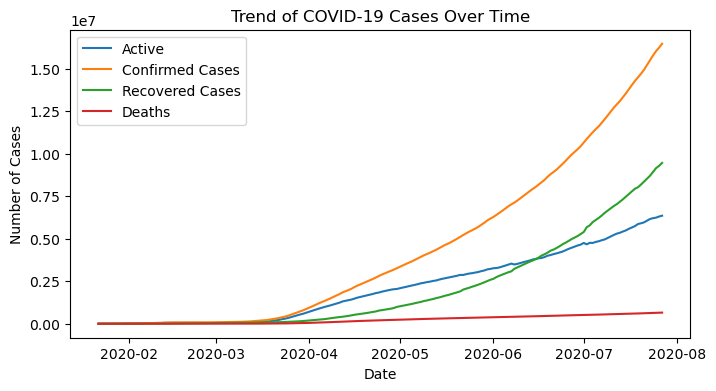

In [5]:
summary_by_date = merged_df.groupby('Date').sum(numeric_only=True).reset_index()
summary_by_date['Date'] = pd.to_datetime(summary_by_date['Date'], errors='coerce')
summary_by_date.set_index('Date', inplace=True)
summary_by_date = summary_by_date.asfreq('D')
summary_by_date = summary_by_date.ffill().bfill()

# Plotting the trend of confirmed, recovered, and death cases over time
plt.figure(figsize=(8, 4))
plt.plot(summary_by_date.index, summary_by_date['Active'], label='Active')
plt.plot(summary_by_date.index, summary_by_date['Confirmed'], label='Confirmed Cases')
plt.plot(summary_by_date.index, summary_by_date['Recovered'], label='Recovered Cases')
plt.plot(summary_by_date.index, summary_by_date['Deaths'], label='Deaths')
plt.title('Trend of COVID-19 Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.show()


#### The provided line chart visualizes the trend of COVID-19 cases over time, focusing on four key metrics:

1. Active Cases: This line represents the number of individuals currently infected with COVID-19. It shows an initial increase followed by a fluctuating pattern, indicating periods of growth and decline in active cases.

2. Confirmed Cases: This line represents the cumulative number of confirmed COVID-19 cases over time. It shows a steady upward trend, indicating the overall spread of the virus.

3. Recovered Cases: This line represents the cumulative number of individuals who have recovered from COVID-19. It also shows an upward trend, indicating the proportion of people who have successfully overcome the infection.

4. Deaths: This line represents the cumulative number of COVID-19 deaths over time. It shows a gradual increase, highlighting the tragic impact of the pandemic.

### 2.2 Analyzing the Top 10 Countries by COVID-19 Impact

The code calculates new columns to understand the severity and progression of the pandemic, handles missing and infinite values to ensure data integrity, and displays the final processed DataFrame

In [6]:
merged_df['Recovery rate'] = merged_df['Recovered'] / merged_df['Confirmed']
merged_df['Death rate'] = merged_df['Deaths'] / merged_df['Confirmed']
merged_df['New death rate'] = merged_df['New deaths'] / merged_df['New cases']
merged_df['New recovered rate'] = merged_df['New recovered'] / merged_df['New cases']

merged_df.fillna({
    'Recovery rate': 0, 
    'Death rate': 0, 
    'New death rate': 0, 
    'New recovered rate': 0
}, inplace=True)

merged_df.replace([float('inf'), -float('inf')], 0, inplace=True)

#print(merged_df[['Recovery rate', 'Death rate', 'New death rate', 'New recovered rate']].isna().sum())

#merged_df.tail()


This code aggregates COVID-19 data by country and calculates various rates per population to gain deeper insights into the impact of the pandemic on different countries.

In [7]:
aggregated_by_country = merged_df.groupby('Country/Region', as_index=False).agg({
    'Confirmed': 'sum',
    'Deaths': 'sum',
    'Recovered': 'sum',
    'New cases': 'sum',
    'New deaths': 'sum',
    'New recovered': 'sum',
    'Recovery rate': 'mean',
    'Death rate': 'mean',
    'New death rate': 'mean',
    'New recovered rate': 'mean'
})


aggregated_population = merged_df.groupby('Country/Region', as_index=False)['Population'].mean()

aggregated_by_country = pd.merge(aggregated_by_country, aggregated_population, on='Country/Region', how='left')

# Calculate rates by population
aggregated_by_country['Confirmed Rate by Population'] = (aggregated_by_country['Confirmed'] / aggregated_by_country['Population']) * 100
aggregated_by_country['New Case Rate by Population'] = (aggregated_by_country['New cases'] / aggregated_by_country['Population']) * 100
aggregated_by_country['Recovery Rate by Population'] = (aggregated_by_country['Recovered'] / aggregated_by_country['Population']) * 100
aggregated_by_country['Death Rate by Population'] = (aggregated_by_country['Deaths'] / aggregated_by_country['Population']) * 100
aggregated_by_country['New Recovery Rate by Population'] = (aggregated_by_country['New recovered'] / aggregated_by_country['Population']) * 100
aggregated_by_country['New Death Rate by Population'] = (aggregated_by_country['New deaths'] / aggregated_by_country['Population']) * 100


### 2.3 Analyzing the Top 10 Countries on the Confirmed and new confirmed Cases

The provided code output highlight the top 10 countries based on two metrics: Confirmed Rate by Population: This metric measures the percentage of the population in each country that has been confirmed with COVID-19. New Case Rate by Population: This metric measures the rate of new COVID-19 cases per population.

Top 10 Countries by Confirmed Rate by Population:
     Country/Region  Confirmed Rate by Population
173              US                    679.748598
136           Qatar                    227.138530
143      San Marino                    220.840945
79            India                    123.873320
3           Andorra                    122.161547
12          Bahrain                    102.843961
35            Chile                     88.517662
177  United Kingdom                     81.045879
102      Luxembourg                     79.967047
92           Kuwait                     72.957903

Top 10 Countries by New Case Rate by Population:
    Country/Region  New Case Rate by Population
173             US                    12.999106
79           India                     4.484492
136          Qatar                     3.903298
12         Bahrain                     2.313395
143     San Marino                     2.086157
35           Chile                     1.818491
127           

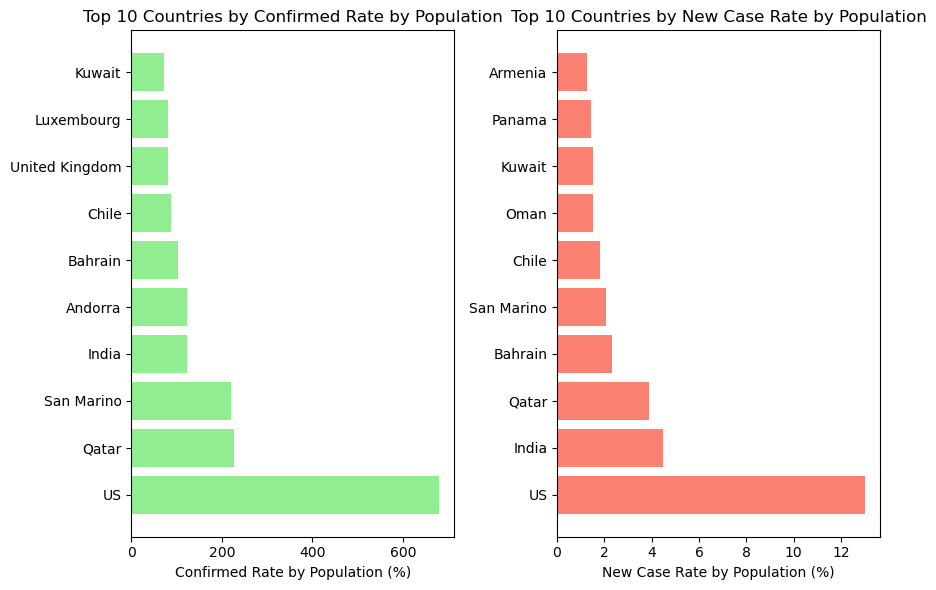

In [8]:
top_10_confirmed = aggregated_by_country[['Country/Region', 'Confirmed Rate by Population']].sort_values('Confirmed Rate by Population', ascending=False).head(10)

top_10_new_cases = aggregated_by_country[['Country/Region', 'New Case Rate by Population']].sort_values('New Case Rate by Population', ascending=False).head(10)

print("Top 10 Countries by Confirmed Rate by Population:")
print(top_10_confirmed)

print("\nTop 10 Countries by New Case Rate by Population:")
print(top_10_new_cases)

plt.figure(figsize=(9, 6))

# Plotting the Top 10 Recovery Rate by Population
plt.subplot(1, 2, 1)
plt.barh(top_10_confirmed['Country/Region'], top_10_confirmed['Confirmed Rate by Population'], color='lightgreen')
plt.xlabel('Confirmed Rate by Population (%)')
plt.title('Top 10 Countries by Confirmed Rate by Population')

# Plotting the Top 10 Death Rate by Population
plt.subplot(1, 2, 2)
plt.barh(top_10_new_cases['Country/Region'], top_10_new_cases['New Case Rate by Population'], color='salmon')
plt.xlabel('New Case Rate by Population (%)')
plt.title('Top 10 Countries by New Case Rate by Population')

plt.tight_layout()
plt.show()


#### Key Observations by Confirmed Rate by Population: 

The US tops the list, indicating a significant proportion of its population has been infected.
Countries like Qatar, San Marino, and Andorra, despite their smaller populations, have relatively high confirmed rates.
This could be due to various factors, including testing rates, population density, and healthcare infrastructure.

#### Key Observations New Case Rate by Population:

While specific data for this time period isn't provided, it's likely that countries with high new case rates are experiencing recent surges in infections. Factors like relaxed public health measures, new variants, or seasonal changes can influence these rates.


### 2.4 Analyzing Recovery and Death Rates by Population

Top 10 Countries by Recovery Rate by Population
This metric indicates the percentage of the population in each country that has recovered from COVID-19.

Top 10 Countries by Death Rate by Population
This metric indicates the percentage of the population in each country that has died from COVID-19.

Top 10 Countries by Recovery Rate by Population:
    Country/Region  Recovery Rate by Population
173             US                   170.745921
136          Qatar                   166.551559
143     San Marino                   123.195238
3          Andorra                    89.383783
12         Bahrain                    78.210069
79           India                    72.062591
35           Chile                    69.476458
102     Luxembourg                    60.557108
78         Iceland                    55.681256
92          Kuwait                    51.567065

Top 10 Countries by Death Rate by Population:
     Country/Region  Death Rate by Population
173              US                 33.363612
143      San Marino                 14.986151
177  United Kingdom                 12.112909
16          Belgium                  8.311347
3           Andorra                  7.017521
157           Spain                  6.486842
85            Italy                  6.133266
61      

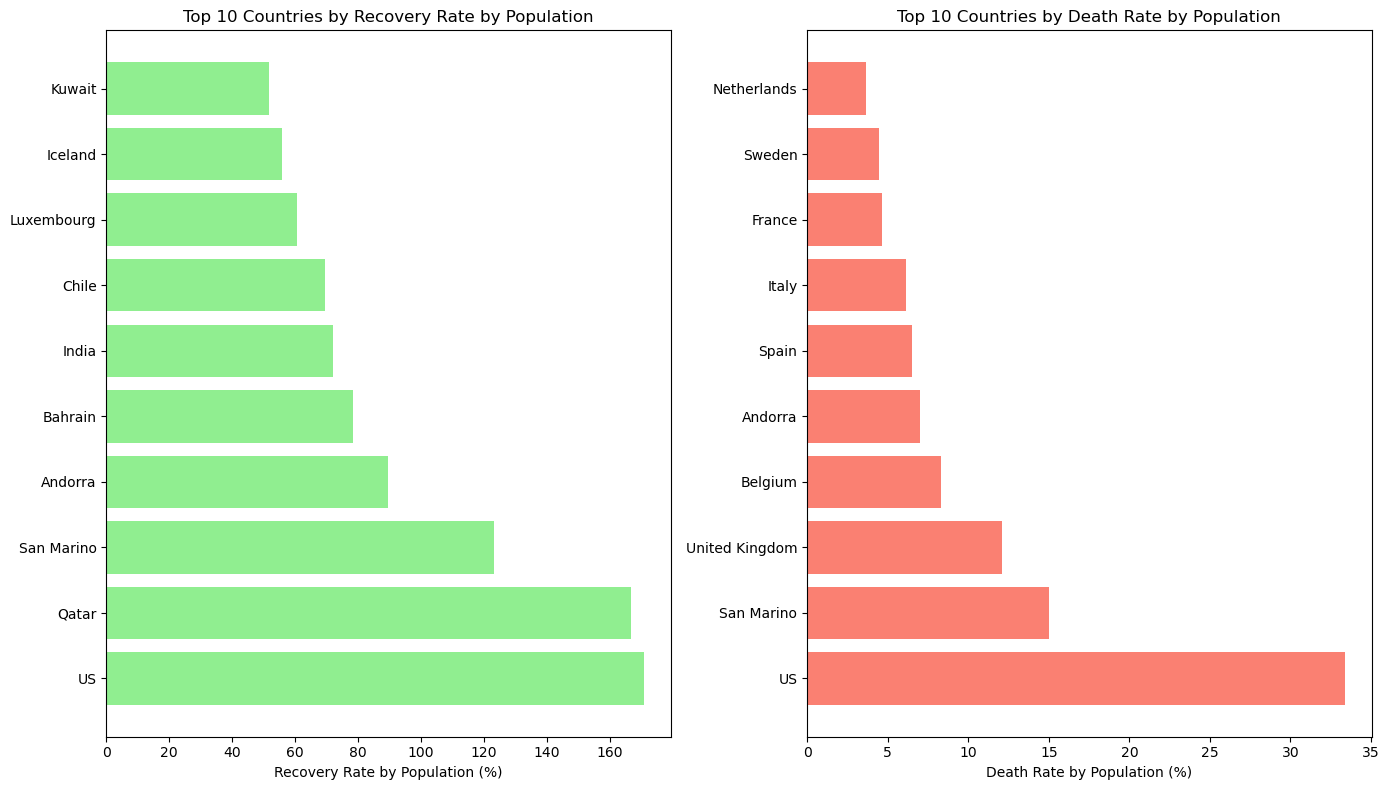

In [9]:
top_10_recovery = aggregated_by_country[['Country/Region', 'Recovery Rate by Population']].sort_values('Recovery Rate by Population', ascending=False).head(10)

top_10_death = aggregated_by_country[['Country/Region', 'Death Rate by Population']].sort_values('Death Rate by Population', ascending=False).head(10)

print("Top 10 Countries by Recovery Rate by Population:")
print(top_10_recovery)

print("\nTop 10 Countries by Death Rate by Population:")
print(top_10_death)

plt.figure(figsize=(14, 8))

# Plotting the Top 10 Recovery Rate by Population
plt.subplot(1, 2, 1)
plt.barh(top_10_recovery['Country/Region'], top_10_recovery['Recovery Rate by Population'], color='lightgreen')
plt.xlabel('Recovery Rate by Population (%)')
plt.title('Top 10 Countries by Recovery Rate by Population')

# Plotting the Top 10 Death Rate by Population
plt.subplot(1, 2, 2)
plt.barh(top_10_death['Country/Region'], top_10_death['Death Rate by Population'], color='salmon')
plt.xlabel('Death Rate by Population (%)')
plt.title('Top 10 Countries by Death Rate by Population')

plt.tight_layout()
plt.show()

#### Key Observations by Recovery Rate by Population:

US Dominance: The US again tops the list, likely due to its large population and high number of recovered cases.
Smaller Nations, Higher Rates: Countries like San Marino, Andorra, and Bahrain, despite their smaller populations, have relatively high recovery rates. This could be attributed to factors like early containment measures, effective healthcare systems, or a less severe strain of the virus in these regions.

#### Key Observations by Death Rate by Population:

US and San Marino: These two countries have the highest death rates per capita, indicating the severity of the pandemic's impact.
European Countries: Several European countries, including the UK, Belgium, Spain, and Italy, have relatively high death rates, highlighting the significant toll the pandemic has taken on these nations.

### 2.5 Analyzing the Top 10 Countries by New Recovery and Death Rates

Top 10 Countries by New Recovery Rate by Population
This metric indicates the rate at which new COVID-19 cases are recovering per population.

Top 10 Countries by New Death Rate by Population
This metric indicates the rate at which new COVID-19 cases are resulting in deaths per population.

Top 10 Countries by New Recovery Rate by Population:
    Country/Region  New Recovery Rate by Population
173             US                         4.017070
136          Qatar                         3.786873
79           India                         2.881950
12         Bahrain                         2.115817
143     San Marino                         1.935883
35           Chile                         1.672305
92          Kuwait                         1.287384
127           Oman                         1.114166
3          Andorra                         1.039106
7          Armenia                         0.899686

Top 10 Countries by New Death Rate by Population:
     Country/Region  New Death Rate by Population
173              US                      0.448460
177  United Kingdom                      0.138903
143      San Marino                      0.123755
79            India                      0.101223
16          Belgium                      0.084711
3           Andorra     

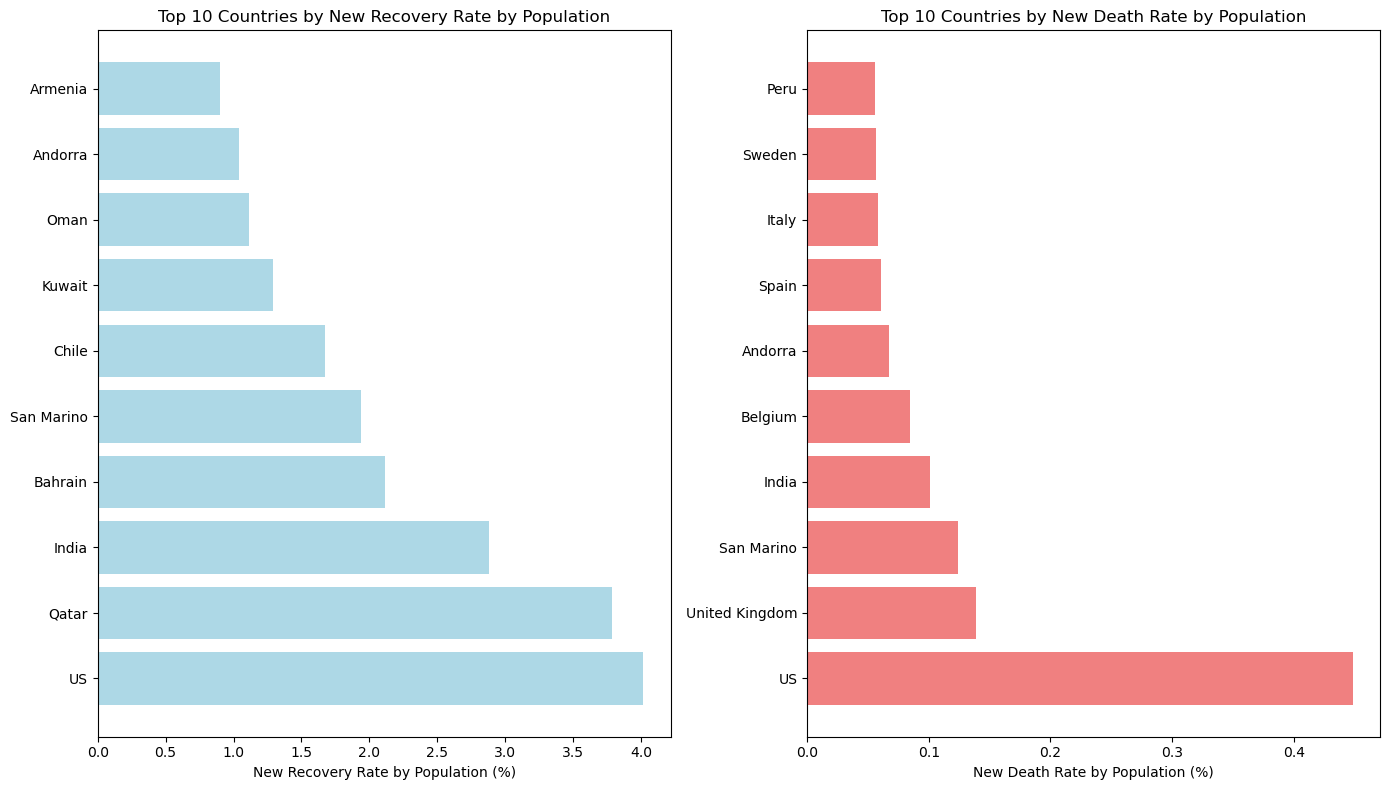

In [10]:
top_10_new_recovery = aggregated_by_country[['Country/Region', 'New Recovery Rate by Population']].sort_values('New Recovery Rate by Population', ascending=False).head(10)

top_10_new_death = aggregated_by_country[['Country/Region', 'New Death Rate by Population']].sort_values('New Death Rate by Population', ascending=False).head(10)


print("Top 10 Countries by New Recovery Rate by Population:")
print(top_10_new_recovery)

print("\nTop 10 Countries by New Death Rate by Population:")
print(top_10_new_death)

plt.figure(figsize=(14, 8))

# Plotting the Top 10 New Recovery Rate by Population
plt.subplot(1, 2, 1)
plt.barh(top_10_new_recovery['Country/Region'], top_10_new_recovery['New Recovery Rate by Population'], color='lightblue')
plt.xlabel('New Recovery Rate by Population (%)')
plt.title('Top 10 Countries by New Recovery Rate by Population')

# Plotting the Top 10 New Death Rate by Population
plt.subplot(1, 2, 2)
plt.barh(top_10_new_death['Country/Region'], top_10_new_death['New Death Rate by Population'], color='lightcoral')
plt.xlabel('New Death Rate by Population (%)')
plt.title('Top 10 Countries by New Death Rate by Population')

plt.tight_layout()
plt.show()


#### Key Observations by New Recovery Rate by Population:

US Dominance: The US continues to lead, suggesting a high rate of recovery among newly infected individuals.
Smaller Nations, Higher Rates: Countries like Qatar, india, Bahrain, and San Marino, despite their smaller populations, have relatively high new recovery rates. This might be due to factors like early containment measures, effective healthcare systems, or a less severe strain of the virus in these regions.

#### Key Observations by New Death Rate by Population:

US and UK: These two countries have the highest new death rates per capita, highlighting the ongoing severity of the pandemic in these regions.
European Countries: Several European countries, including Belgium, Spain, and Italy, continue to have relatively high new death rates.

## 3. Feature Engineering and Correlation Analysis

#### Feature Engineering:
It selects relevant features for predicting confirmed COVID-19 cases.
It splits the data into training and testing sets.
It scales the features to improve model performance.

#### Correlation Analysis:

It calculates the correlation between the 'Confirmed' cases and other features.
It identifies the features that are most strongly correlated with the number of confirmed cases.
By performing these steps, the code prepares the data for machine learning modeling, ensuring that the model can learn meaningful patterns and make accurate predictions.

In [11]:
X = merged_df[['Confirmed',	'Deaths',	'Recovered',	'Active',	'New cases',	'New deaths',	'New recovered',	'Population',	'Recovery rate', 'Death rate',	'New death rate',	'New recovered rate']]


correlation_matrix = X.corr()

confirmed_rate_corr = correlation_matrix['Confirmed'].sort_values(ascending=False)

print("Top Correlations with 'Confirmed':")
print(confirmed_rate_corr)

X = merged_df[['Confirmed', 'Recovered', 'Active','New cases', 'New deaths', 'New recovered']]  
y = merged_df['Deaths']  

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Top Correlations with 'Confirmed':
Confirmed             1.000000
Active                0.949940
Deaths                0.912016
Recovered             0.894418
New cases             0.893966
New recovered         0.675623
New deaths            0.602815
Population            0.170080
Death rate            0.103336
Recovery rate         0.068686
New recovered rate    0.012640
New death rate        0.007866
Name: Confirmed, dtype: float64


## 4. Model Evaluation

This code snippet essentially trains an XGBoost model, generates predictions on unseen data, and then uses two popular regression evaluation metrics—MSE and R2—to assess how well the predictions match the actual values.

In [15]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

# Print the results
print(f"XGBoost - MSE: {mse_xgb}, R²: {r2_xgb}, MAE: {mae_xgb}")


XGBoost - MSE: 1114649.8729887053, R²: 0.9773914217948914, MAE: 162.05468139506715


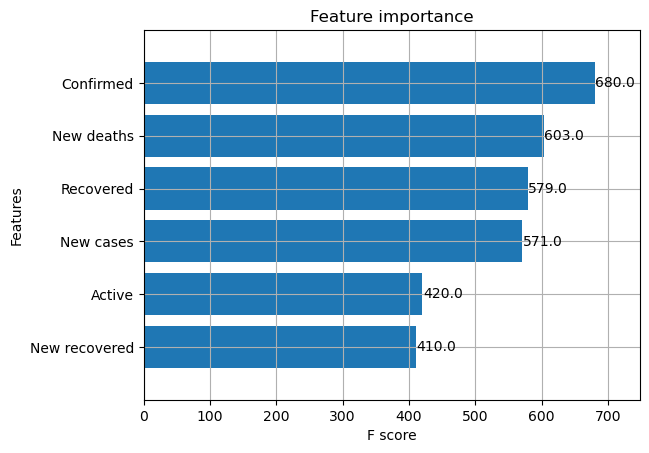

         Feature  Importance
2         Active    0.750335
0      Confirmed    0.168487
5  New recovered    0.034304
4     New deaths    0.022043
3      New cases    0.015522
1      Recovered    0.009309


In [16]:
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Assuming you have your data ready in X_train and y_train
# Train the model
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)

# Plot feature importance using plot_importance
plot_importance(xgb_model, importance_type='weight', max_num_features=10, height=0.8)
plt.show()

# Alternatively, you can get feature importances programmatically
importance = xgb_model.feature_importances_
features = X_train.columns  # Assuming X_train is a DataFrame

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)


### **Conclusion**

In this notebook, we have developed a machine learning model using the **XGBoost Regressor** to predict COVID-19 mortality rates. By leveraging global COVID-19 datasets and integrating population data, we were able to clean, standardize, and prepare the data for modeling. The key features identified—**Active Cases**, **Confirmed Cases**, and **New Deaths**—proved to be the most influential in predicting mortality trends, with **Active Cases** emerging as the strongest predictor.

Through **Exploratory Data Analysis (EDA)**, we identified key insights such as the strong correlation between healthcare system strain and high death rates, especially in countries like the **US**, **San Marino**, and the **UK**. These findings underscore the importance of actively monitoring both confirmed cases and new deaths to predict and manage future trends.

The model achieved impressive performance metrics: an **R² value of 0.97**, indicating that 97% of the variance in mortality can be explained by the model, and an **MSE of 1,114,649.87**, with a **Mean Absolute Error (MAE)** of 162.05 deaths—demonstrating high accuracy in mortality predictions.

**Next steps** for improving this model include integrating additional features, such as vaccination rates, healthcare infrastructure, and socio-economic factors, and applying the model in real-time scenarios for enhanced decision-making. Future research could also extend this approach to other regions and provide insights into how public health measures impact mortality trends.
